
# Builtinmodels - nistgauss


[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(exponential, prefix='exp_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 250
    # variables        = 8
    chi-square         = 1247.52821
    reduced chi-square = 5.15507524
    Akaike info crit   = 417.864631
    Bayesian info crit = 446.036318
    R-squared          = 0.99648654
[[Variables]]
    exp_amplitude:  99.0183278 +/- 0.53748593 (0.54%) (init = 162.2102)
    exp_decay:      90.9508853 +/- 1.10310778 (1.21%) (init = 93.24905)
    g1_amplitude:   4257.77360 +/- 42.3836478 (1.00%) (init = 2000)
    g1_center:      107.030956 +/- 0.15006851 (0.14%) (init = 105)
    g1_sigma:       16.6725772 +/- 0.16048381 (0.96%) (init = 15)
    g1_fwhm:        39.2609181 +/- 0.37791049 (0.96%) == '2.3548200*g1_sigma'
    g1_height:      101.880230 +/- 0.59217173 (0.58%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:   2493.417

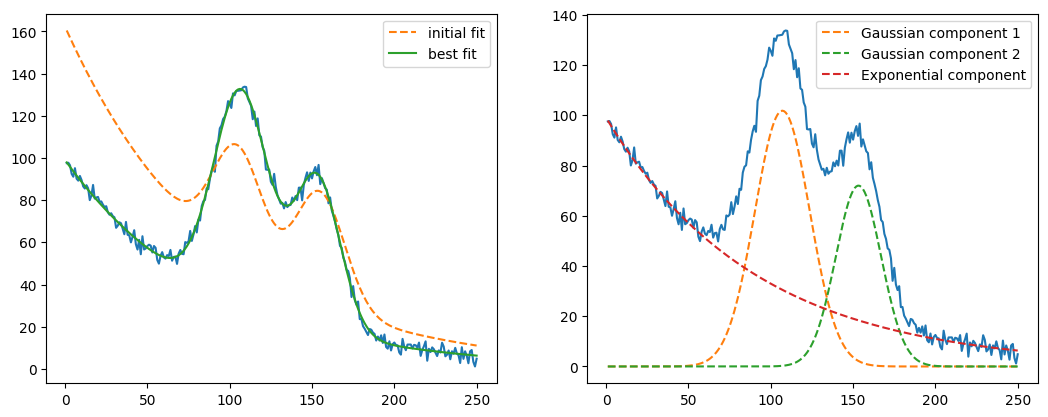

In [1]:
# <examples/doc_builtinmodels_nistgauss.py>
import os
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import ExponentialModel, GaussianModel

dpath='./data'  # data path

# --- Load data (skip header) ---
file='NIST_Gauss2.dat' # data
file=os.path.join(
    dpath,
    file
)

dat = np.loadtxt(file)
x = dat[:, 1]
y = dat[:, 0]

exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params(center=dict(value=105, min=75, max=125),
                               sigma=dict(value=15, min=0),
                               amplitude=dict(value=2000, min=0)))

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params(center=dict(value=155, min=125, max=175),
                               sigma=dict(value=15, min=0),
                               amplitude=dict(value=2000, min=0)))

mod = gauss1 + gauss2 + exp_mod

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(correl_mode='table'))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y)
axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
axes[1].plot(x, comps['exp_'], '--', label='Exponential component')
axes[1].legend()

plt.show()
# <end examples/doc_builtinmodels_nistgauss.py>

[[Model]]
    ((Model(exponential, prefix='exp_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 250
    # variables        = 8
    chi-square         = 1247.52821
    reduced chi-square = 5.15507524
    Akaike info crit   = 417.864631
    Bayesian info crit = 446.036318
    R-squared          = 0.99648654
[[Variables]]
    exp_amplitude:  99.0183262 +/- 0.53748782 (0.54%) (init = 100)
    exp_decay:      90.9508911 +/- 1.10310756 (1.21%) (init = 100)
    g1_amplitude:   4257.77356 +/- 42.3840086 (1.00%) (init = 2000)
    g1_center:      107.030956 +/- 0.15007019 (0.14%) (init = 100)
    g1_sigma:       16.6725771 +/- 0.16048228 (0.96%) (init = 100)
    g2_amplitude:   2493.41709 +/- 36.1703087 (1.45%) (init = 2000)
    g2_center:      153.270102 +/- 0.19467163 (0.13%) (init = 100)
    g2_sigma:       13.8069446 +/- 0.18680492 (1.35%) (init = 150)
[[Correlations]

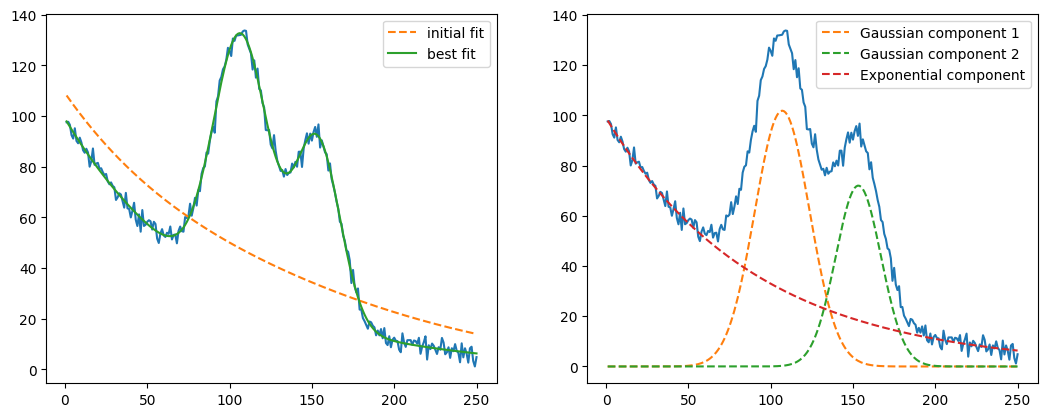

In [2]:
"""Basic model lineshapes and distribution functions."""

from numpy import (arctan, copysign, cos, exp, isclose, isnan, log, log1p,
                   maximum, minimum, pi, real, sign, sin, sqrt, where)
from scipy.special import betaln as betalnfcn
from scipy.special import erf, erfc
from scipy.special import gamma as gamfcn
from scipy.special import loggamma as loggammafcn
from scipy.special import wofz

log2 = log(2)
s2pi = sqrt(2*pi)
s2 = sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

functions = ('gaussian', 'gaussian2d', 'lorentzian', 'voigt',
             'pvoigt', 'moffat', 'pearson4', 'pearson7',
             'breit_wigner', 'damped_oscillator', 'dho', 'logistic',
             'lognormal', 'students_t', 'expgaussian', 'doniach',
             'skewed_gaussian', 'skewed_voigt',
             'thermal_distribution', 'bose', 'fermi', 'step',
             'rectangle', 'exponential', 'powerlaw', 'linear',
             'parabolic', 'sine', 'expsine', 'split_lorentzian')


def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(copysign(max(tiny, abs(value)), value))


def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


def exponential(x, amplitude=1, decay=1):
    """Return an exponential function.

    exponential(x, amplitude, decay) = amplitude * exp(-x/decay)

    """
    decay = not_zero(decay)
    return amplitude * exp(-x/decay)


def powerlaw(x, amplitude=1, exponent=1.0):
    """Return the powerlaw function.

    powerlaw(x, amplitude, exponent) = amplitude * x**exponent

    """
    return amplitude * x**exponent


def linear(x, slope=1.0, intercept=0.0):
    """Return a linear function.

    linear(x, slope, intercept) = slope * x + intercept

    """
    return slope * x + intercept


import os
import lmfit
import numpy as np
import matplotlib.pyplot as plt


dpath='./data'  # data path

# --- Load data (skip header) ---
file='NIST_Gauss2.dat' # data
file=os.path.join(
    dpath,
    file
)

dat = np.loadtxt(file)
x = dat[:, 1]
y = dat[:, 0]

params = lmfit.Parameters()

par = lmfit.Parameters()
par.add('exp_amplitude', value=100, vary=True)
par.add('exp_decay', value=100, vary=True)
params.update(par)
#
par = lmfit.Parameters()
par.add('g1_amplitude', value=2000, vary=True)
par.add('g1_center', value=100, vary=True)
par.add('g1_sigma', value=100, vary=15)
params.update(par)
#
par = lmfit.Parameters()
par.add('g2_amplitude', value=2000, vary=True)
par.add('g2_center', value=100, vary=True)
par.add('g2_sigma', value=150, vary=15)
params.update(par)

mod = lmfit.Model(exponential, prefix='exp_') + lmfit.Model(gaussian, prefix='g1_') + lmfit.Model(gaussian, prefix='g2_') 

init = mod.eval(params, x=x)
out = mod.fit(y, params, x=x)

print(out.fit_report(correl_mode='table'))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y)
axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
axes[1].plot(x, comps['exp_'], '--', label='Exponential component')
axes[1].legend()

plt.show()

[[Model]]
    ((Model(exponential, prefix='c1_') + Model(gaussian, prefix='c2_')) + Model(gaussian, prefix='c3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 250
    # variables        = 8
    chi-square         = 1247.52821
    reduced chi-square = 5.15507524
    Akaike info crit   = 417.864631
    Bayesian info crit = 446.036318
    R-squared          = 0.99648654
[[Variables]]
    c1_amplitude:  99.0183262 +/- 0.53748782 (0.54%) (init = 100)
    c1_decay:      90.9508911 +/- 1.10310756 (1.21%) (init = 100)
    c2_amplitude:  4257.77356 +/- 42.3840086 (1.00%) (init = 2000)
    c2_center:     107.030956 +/- 0.15007019 (0.14%) (init = 100)
    c2_sigma:      16.6725771 +/- 0.16048228 (0.96%) (init = 100)
    c3_amplitude:  2493.41709 +/- 36.1703087 (1.45%) (init = 2000)
    c3_center:     153.270102 +/- 0.19467163 (0.13%) (init = 100)
    c3_sigma:      13.8069446 +/- 0.18680492 (1.35%) (init = 150)
[[Correlations]] 
  +---

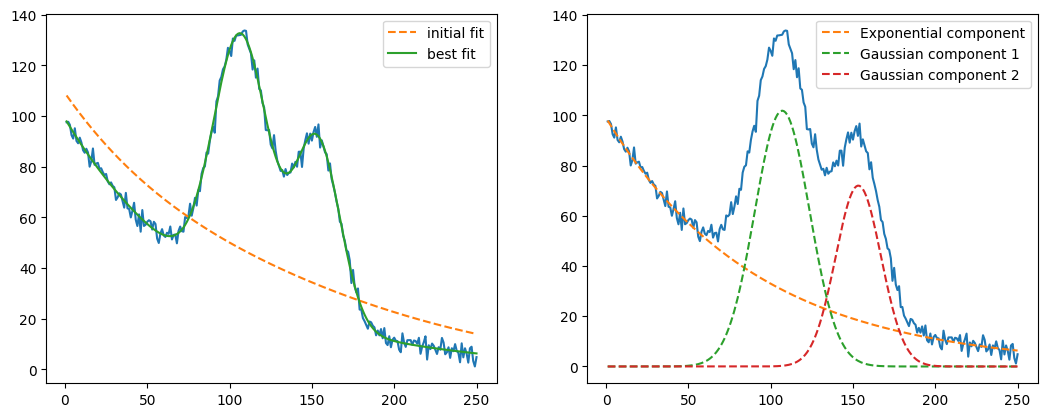

[Model(exponential, prefix='c1_'),
 Model(gaussian, prefix='c2_'),
 Model(gaussian, prefix='c3_')]

In [6]:
"""Basic model lineshapes and distribution functions."""

from numpy import (arctan, copysign, cos, exp, isclose, isnan, log, log1p,
                   maximum, minimum, pi, real, sign, sin, sqrt, where)
from scipy.special import betaln as betalnfcn
from scipy.special import erf, erfc
from scipy.special import gamma as gamfcn
from scipy.special import loggamma as loggammafcn
from scipy.special import wofz

log2 = log(2)
s2pi = sqrt(2*pi)
s2 = sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

functions = ('gaussian', 'gaussian2d', 'lorentzian', 'voigt',
             'pvoigt', 'moffat', 'pearson4', 'pearson7',
             'breit_wigner', 'damped_oscillator', 'dho', 'logistic',
             'lognormal', 'students_t', 'expgaussian', 'doniach',
             'skewed_gaussian', 'skewed_voigt',
             'thermal_distribution', 'bose', 'fermi', 'step',
             'rectangle', 'exponential', 'powerlaw', 'linear',
             'parabolic', 'sine', 'expsine', 'split_lorentzian')


def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(copysign(max(tiny, abs(value)), value))


def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


def exponential(x, amplitude=1, decay=1):
    """Return an exponential function.

    exponential(x, amplitude, decay) = amplitude * exp(-x/decay)

    """
    decay = not_zero(decay)
    return amplitude * exp(-x/decay)


def powerlaw(x, amplitude=1, exponent=1.0):
    """Return the powerlaw function.

    powerlaw(x, amplitude, exponent) = amplitude * x**exponent

    """
    return amplitude * x**exponent


def linear(x, slope=1.0, intercept=0.0):
    """Return a linear function.

    linear(x, slope, intercept) = slope * x + intercept

    """
    return slope * x + intercept


import os
import lmfit
import operator
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt


dpath='./data'  # data path

# --- Load data (skip header) ---
file='NIST_Gauss2.dat' # data
file=os.path.join(
    dpath,
    file
)

dat = np.loadtxt(file)
x = dat[:, 1]
y = dat[:, 0]

params = lmfit.Parameters()

par = lmfit.Parameters()
par.add('c1_amplitude', value=100, vary=True)
par.add('c1_decay', value=100, vary=True)
params.update(par)
#
par = lmfit.Parameters()
par.add('c2_amplitude', value=2000, vary=True)
par.add('c2_center', value=100, vary=True)
par.add('c2_sigma', value=100, vary=15)
params.update(par)
#
par = lmfit.Parameters()
par.add('c3_amplitude', value=2000, vary=True)
par.add('c3_center', value=100, vary=True)
par.add('c3_sigma', value=150, vary=15)
params.update(par)


func_list = [
    exponential,
    gaussian,
    gaussian
]
model_list = [lmfit.Model(func, prefix=f'c{i+1}_') for i, func in enumerate(func_list)]
model_list


symbols = ['+', '+']

op_map = {
    '+': operator.add,
    '*': operator.mul,
    '-': operator.sub,
    '/': operator.truediv,
}

mod = reduce(
    lambda x, y: op_map[y[1]](x, y[0]),
    zip(model_list[1:], symbols),
    model_list[0]
)

init = mod.eval(params, x=x)
out = mod.fit(y, params, x=x)

print(out.fit_report(correl_mode='table'))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y)
axes[1].plot(x, comps['c1_'], '--', label='Exponential component')
axes[1].plot(x, comps['c2_'], '--', label='Gaussian component 1')
axes[1].plot(x, comps['c3_'], '--', label='Gaussian component 2')
axes[1].legend()

plt.show()

out.components

In [4]:
from sklearn.metrics import r2_score

r2_score(y, out.best_fit)

0.9964865391932065

In [5]:
from functools import reduce
import operator

nums = [1, 2, 3, 4]
symbols = ['*', '+', '*']

op_map = {
    '+': operator.add,
    '*': operator.mul,
}

result = reduce(
    lambda x, y: op_map[y[1]](x, y[0]),
    zip(nums[1:], symbols),
    nums[0]
)

print(result)


mod = (
    ExponentialModel(prefix='c1_') +
    GaussianModel(prefix='c2_') +
    GaussianModel(prefix='c3_') 
         )

mod

20


((Model(exponential, prefix='c1_') + Model(gaussian, prefix='c2_')) + Model(gaussian, prefix='c3_'))